In [1]:
# from __future__ import annotations

import math
import xml.etree.ElementTree as ET

import chess

from typing import Dict, Iterable, Optional, Tuple, Union
from chess import Color, IntoSquareSet, Square

from copy import deepcopy
import warnings

import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

# Graphs

In [2]:
def visualise_graph(input_G):
    colors = []

    for node in input_G:
        colors.append(input_G.nodes[node]['color'])
        
    nx.draw(G, with_labels=True, node_color=colors, font_weight='bold')
    plt.show()
    
class DFSWrapper(object):
    
    def __init__(
        self,
        graph,
        color_domain
    ):
        self.graph = graph
        self.color_domain = color_domain
        self.n = graph.number_of_nodes()
        
        self.result = None
        
    def get_constraint(self, graph, i, v):
        if graph is None:
            return None
        for node in graph.neighbors(i):
            if graph.nodes[node]['color'] == v:
                return False
        return True    
        
    def run_colorization(self):
        self.result = self.dfs(0, self.graph)
        if self.result is None:
            print('Solution does not exist')
        else:
            print('Solution was found')
            visualise_graph(self.result)

    def dfs(self, i, g_t):
        g = g_t.copy()
        if i > self.n - 1:
            return g
        for v in self.color_domain:
            p = self.get_constraint(g, i, v)
            if p:
                g.nodes[i]['color'] = v
                g = self.dfs(i+1, g)
                if g is not None:
                    return g
        return None

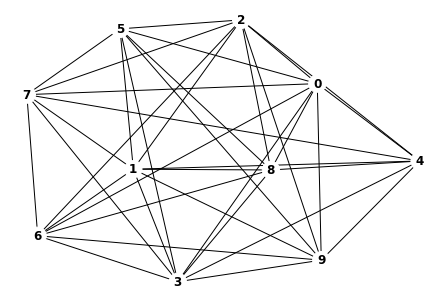

In [3]:
G = nx.turan_graph(10, 4)
for node in G:
    G.nodes[node]['color'] = 'white'
    
visualise_graph(G)

Solution was found


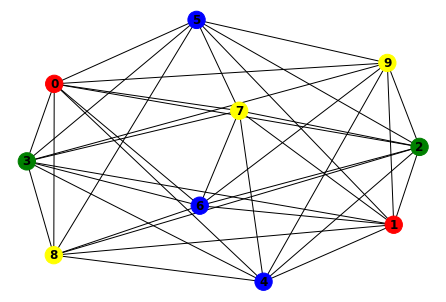

In [4]:
dfs_temp = DFSWrapper(
    G, 
    ['red', 'green', 'blue', 'yellow']
)

dfs_temp.run_colorization()

# Chess class

In [5]:
def peshka_rule_attack(x, y, x_ref, y_ref):
    possible_coords = [
        (x-1, y+1),
        (x-1, y-1),
        (x, y)
    ]
    for x_pos, y_pos in possible_coords:
        if x_pos == x_ref and y_pos == y_ref:
            return True
    return False

def peshka_rule_defense(x, y, desk, n):
    possible_coords = [
        (x-1, y+1),
        (x-1, y-1),
        (x, y)
    ]
    figure_sum = sum(desk[el[0], el[1]] for el in possible_coords if (0<=el[0]<n) and (0<=el[1]<n)) 
    return bool(figure_sum)

def king_rule_attack(x, y, x_ref, y_ref):
    possible_coords = [
        (x+1, y+1),
        (x+1, y),
        (x+1, y-1),
        (x-1, y+1),
        (x, y+1),
        (x, y-1),
        (x-1, y-1),
        (x-1, y),
        (x, y),
    ]
    for x_pos, y_pos in possible_coords:
        if x_pos == x_ref and y_pos == y_ref:
            return True
    return False

def king_rule_defense(x, y, desk, n):
    possible_coords = [
        (x+1, y+1),
        (x+1, y),
        (x+1, y-1),
        (x-1, y+1),
        (x, y+1),
        (x, y-1),
        (x-1, y-1),
        (x-1, y),
        (x, y),
    ]
    figure_sum = sum(desk[el[0], el[1]] for el in possible_coords if (0<=el[0]<n) and (0<=el[1]<n)) 
    return bool(figure_sum)

def tura_rule_attack(x, y, x_ref, y_ref):
    if x == x_ref or y == y_ref:
        return True
    else:
        return False
    
def tura_rule_deffense(x, y, desk, n):
    figure_sum = desk[x,y] + desk[x,:].sum() + desk[:,y].sum()
    return bool(figure_sum)

In [6]:
class ChessField(object):
    
    def __init__(
        self,
        size: int,
        figure_config,
    ):
        self.desk = np.zeros((size, size))
        self.size = size
        self.figures = []
        self.figure_config = dict()
        for el in figure_config:
            n_figures, figure_color, figure_number, figure_name, figure_rule = el
            self.figure_config[figure_name] = {
                "color": figure_color,
                "n": n_figures,
                "number": figure_number,
                "const_def": figure_rule[0],
                "const_atack": figure_rule[1]
            }
            coords = np.random.randint(low=0, high=size, size=(n_figures, 2))
            for coord in coords:
                self.desk[coord[0], coord[1]] = figure_number
            self.figures += [(coord, figure_name) for coord in coords]
            
    def show_field(self):
        field = np.zeros((self.size,self.size,3), dtype=np.uint8)
        for figure in self.figures:
            coord, name = figure
            field[coord[0], coord[1]] = self.figure_config[name]['color']

        plt.imshow(field)
        plt.show()
        
    def zero_field(self):
        self.desk = np.zeros((self.size, self.size))
        self.figure = [(None, el[1]) for el in self.figures]

In [7]:
temp_field = ChessField(
    10,
    # R G B
    [
        (5, (255, 0, 0), 1, 'peshka', (peshka_rule_defense, peshka_rule_attack)),
        (5, (0, 255, 0), 2, 'king', (king_rule_defense, king_rule_attack)),
        (3, (0, 0, 255), 3, 'tura', (tura_rule_deffense, tura_rule_attack))
    ]
)

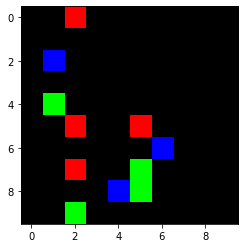

In [8]:
temp_field.show_field()

# Chess DFS

In [21]:
class DFSChessWrapper(object):
    
    def __init__(
        self,
        chess_class
    ):
        self.graph = chess_class
        self.n = len(chess_class.figures)
        
        self.result = None
        
    def get_constraint(self, graph, i, x, y):
        
        if graph is None:
            return None
        
        _, figure_name = graph.figures[i]
        if graph.figure_config[figure_name]['const_def'](x, y, graph.desk, graph.size):
            return False
        
        for idx, figure in enumerate(graph.figures):
            if idx != i:
                figure_coord, figure_name = figure
                if figure_coord is not None:
                    do_strike = graph.figure_config[figure_name]['const_atack'](figure_coord[0], figure_coord[1], x, y)
                    print(figure_coord, figure_name, do_strike, x, y)
                    if do_strike:
                        return False
        return True   
        
    def run_colorization(self):
        self.graph.zero_field()
        self.result = self.dfs(0, self.graph)
        if self.result is None:
            print('Solution does not exist')
        else:
            print('Solution was found')
            self.result.show_field()

    def dfs(self, i, g_t):
        g = deepcopy(g_t)
        if i >= self.n:
            return g
        for x in range(0, self.graph.size):
            for y in range(0, self.graph.size):
                p = self.get_constraint(g, i, x, y)
                if p:
                    g.figures[i] = (np.array([x, y]), g.figures[i][1])
                    g.desk[x,y] = g.figure_config[g.figures[i][1]]['number']
                    g = self.dfs(i+1, g)
                    if g is not None:
                        return g
        return None

In [22]:
temp_field.figures

[(array([2, 1]), 'peshka'),
 (array([5, 5]), 'peshka'),
 (array([7, 2]), 'peshka'),
 (array([0, 2]), 'peshka'),
 (array([5, 2]), 'peshka'),
 (array([9, 2]), 'king'),
 (array([8, 5]), 'king'),
 (array([6, 6]), 'king'),
 (array([4, 1]), 'king'),
 (array([7, 5]), 'king'),
 (array([2, 1]), 'tura'),
 (array([6, 6]), 'tura'),
 (array([8, 4]), 'tura')]

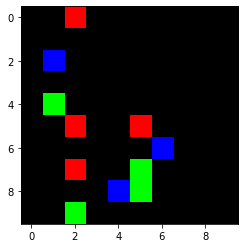

In [23]:
temp_field.show_field()

In [24]:
temp_dfs_chess = DFSChessWrapper(temp_field)

In [25]:
g = deepcopy(temp_field)

In [32]:
p = temp_dfs_chess.get_constraint(g, 0, 0, 0)
p

[5 5] peshka False 0 0
[7 2] peshka False 0 0
[0 2] peshka False 0 0
[5 2] peshka False 0 0
[9 2] king False 0 0
[8 5] king False 0 0
[6 6] king False 0 0
[4 1] king False 0 0
[7 5] king False 0 0
[2 1] tura False 0 0
[6 6] tura False 0 0
[8 4] tura False 0 0


True

In [14]:
def dfs2(i, temp_dfs_chess, g_t):
    g = deepcopy(g_t)
    if i >= temp_dfs_chess.n:
        return g
    for x in range(0, temp_dfs_chess.graph.size):
        for y in range(0, temp_dfs_chess.graph.size):
            p = temp_dfs_chess.get_constraint(g, i, x, y)
            print(p)
            if p:
                g.figures[i] = (np.array([x, y]), g.figures[i][1])
                g.desk[x,y] = g.figure_config[g.figures[i][1]]['number']
                g = dfs2(i+1, temp_dfs_chess, g)
                if g is not None:
                    return g
    return None

In [163]:
dfs2(0, temp_dfs_chess, temp_field)

[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
False
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
False
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
False
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king False
[9 4] king False
[1 7] tura False
[3 4] tura False
[8 6] tura False
True
[0 3] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
False
[0 3] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
False
[0 3] peshka False
[1 7] peshka False


[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
[3 4] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king False
[9 4] king False
[1 7] tura False
[3 4] tura False
[8 6] tura False
[0 3] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
[0 3] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka False
[3 5] king False
[7 4] king False
[6 5] king False
[0 1] king True
[0 3] peshka False
[1 7] peshka False
[0 7] peshka False
[0 7] peshka Fal

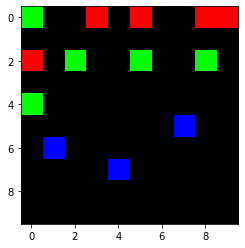

In [165]:
temp_dfs_chess = DFSChessWrapper(temp_field)

temp_dfs_chess.run_colorization()

# Chess Filtering

In [33]:
class FilteringChessWrapper(object):
    
    def __init__(
        self,
        chess_class,
        use_all_domains
    ):
        self.graph = deepcopy(chess_class)
        self.n = len(chess_class.figures)
        
        self.result = None
        
        universal_domain = [(x, y) for x in range(0, self.graph.size) for y in range(0, self.graph.size)]
        self.domains = [deepcopy(universal_domain) for _ in range(len(self.graph.figures))]
        if not use_all_domains:
            for i in range(len(self.domains) - 1):
                n_to_drop = np.random.randint(0, len(universal_domain)-2)
                for _ in range(n_to_drop):
                    drop_id = np.random.randint(0, len(self.domains[i]))
                    self.domains[i].pop(drop_id)
            last_domain_preserve = np.random.randint(0, len(universal_domain))
            self.domains[-1] = [self.domains[-1][last_domain_preserve]]
        
    def get_constraint_one(self, graph, i, xi, yi, j, xj, yj):
        
        _, figure_name = graph.figures[i]
        if graph.figure_config[figure_name]['const_atack'](xi, yi, xj, yj):
            return False
        
        _, figure_name = graph.figures[j]
        if graph.figure_config[figure_name]['const_atack'](xj, yj, xi, yi):
            return False
        
        return True
    
    def get_constraint(self, graph, i, vi, j, dj):
        return not any(self.get_constraint_one(graph, i, vi[0], vi[1], j, vj[0], vj[1]) for vj in dj)
        
    def run_colorization(self):
        for i in range(len(self.graph.figures)):
            self.filtering(i)
            if len(self.domains[i]) == 0:
                print('Solution was not found')
                return None
            self.domains[i] = [self.domains[i][0]]
            
        for i in range(len(self.domains)):
            self.graph.figures[i] = (np.array(self.domains[i][0]), self.graph.figures[i][1])
            
        self.graph.show_field()

    def filtering(self, i):
        for j in range(0, len(self.graph.figures)):
            if j != i:
                self.revise(i, j)
        
    def revise(self, i, j):
        old_domain = deepcopy(self.domains[i])
        current_domain = deepcopy(self.domains[i])
        for  v in current_domain:
            if self.get_constraint(self.graph, i, v, j, self.domains[j]):
                current_domain.remove(v)
                
        if set(old_domain) != set(current_domain):
            self.domains[i] = current_domain
            for k in range(0, len(self.graph.figures)):
                if k not in [i, j]:
                    self.revise(i, k)
                
    def handle_new_domain(self, i, k, domain):
        self.domains[i] = domain
        self.revise(i, k)

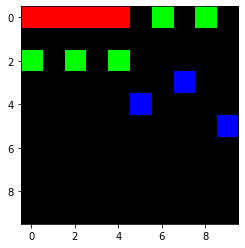

In [34]:
filt_temp = FilteringChessWrapper(temp_field, use_all_domains=True)

filt_temp.run_colorization()

# Chess DB

In [13]:
class DBChessWrapper(object):
    
    def __init__(
        self,
        chess_class,
        timeout: int = 100,
        distributed_mode: bool = True
    ):
        self.graph = deepcopy(chess_class)
        self.n = len(chess_class.figures)
        self.timeout = timeout
        self.distributed_mode = distributed_mode
        
        self.result = None
        
    def get_constraint_one(self, graph, i, xi, yi, j, xj, yj):
        
        _, figure_name = graph.figures[i]
        if graph.figure_config[figure_name]['const_atack'](xi, yi, xj, yj):
            return False
        
        _, figure_name = graph.figures[j]
        if graph.figure_config[figure_name]['const_atack'](xj, yj, xi, yi):
            return False
        
        return True
    
    def evaluate_position(self, graph, i, x, y):
        benefit = 0
        for other_id in range(self.n):
            if other_id != i:
                other_coords = graph.figures[other_id][0]
                benefit += self.get_constraint_one(graph, i, x, y, other_id, other_coords[0], other_coords[1])
        return benefit

    def send_improve(self, graph, i):
        
        current_coords = graph.figures[i][0]
        current_benefit = self.evaluate_position(graph, i, current_coords[0], current_coords[1])
        
        possible_values = []
        possible_benefit = []
        
        for x in range(self.graph.size):
            for y in range(self.graph.size):
                if x != current_coords[0] and y != current_coords[1]:
                    possible_values.append((x,y))
                    possible_benefit.append(self.evaluate_position(graph, i, x, y))
                    
        possible_benefit = np.array(possible_benefit) - current_benefit
        some_postive_benefit = possible_benefit.max() > 0
        possible_indices = np.where(possible_benefit == possible_benefit.max())[0]
        best_index = np.random.choice(possible_indices)
        best_benefit = possible_benefit[best_index]
        best_value = possible_values[best_index]
                
        return best_value, best_benefit, some_postive_benefit
    
    def check_convergance(self, graph):
        all_benefits = []
        for i in range(self.n):
            current_coords = graph.figures[i][0]
            all_benefits.append(self.evaluate_position(graph, i, current_coords[0], current_coords[1]))
        return np.all(np.array(all_benefits) == (self.n - 1)), np.sum(all_benefits)
    
    def run_one_loop(self, graph):
        for i in range(self.n):
            best_value, best_benefit, some_postive_benefit = self.send_improve(graph, i)
            if some_postive_benefit:
                graph.figures[i] = (np.array(best_value), graph.figures[i][1])
        return graph
    
    def run_one_loop_distributed(self, graph):
        best_values = []
        do_benefits = []
        
        for i in range(self.n):
            best_value, best_benefit, some_postive_benefit = self.send_improve(graph, i)
            best_values.append(best_value)
            do_benefits.append(some_postive_benefit)
            
        for i in range(self.n):
            if do_benefits[i]:
                graph.figures[i] = (np.array(best_values[i]), graph.figures[i][1])
                
        return graph
    
    def run_colorization(self):
        new_graph = deepcopy(self.graph)
        number_of_loops = 0
        all_benefit_values = []
        
        while number_of_loops < self.timeout:
            if self.distributed_mode:
                new_graph = self.run_one_loop_distributed(new_graph)
            else:
                new_graph = self.run_one_loop(new_graph)
            converged, all_benefit_value = self.check_convergance(new_graph)
            all_benefit_values.append(all_benefit_value)
            number_of_loops += 1
            if converged:
                break
        if converged:
            print(f"Convergence taken: {number_of_loops}")
            self.result = new_graph
            new_graph.show_field()
        else:
            print("Not converged")
            
        return all_benefit_values

Convergence taken: 19


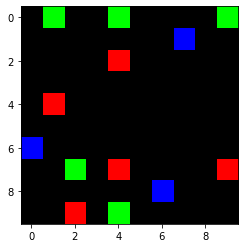

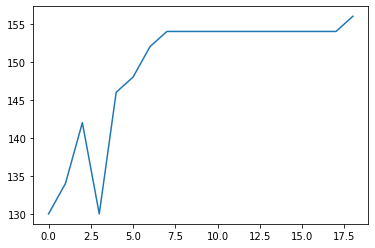

In [14]:
temp_db = DBChessWrapper(temp_field, distributed_mode=True)

some_values = temp_db.run_colorization()

plt.plot(some_values)

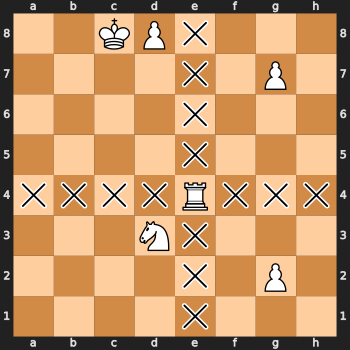

In [15]:
import chess
import chess.svg

board = chess.Board("2KP4/6P1/8/8/4R3/3N4/6P1/8 w - - 0 1")
squares = board.attacks(chess.E4)

chess.svg.board(board, squares=squares, size=350)  

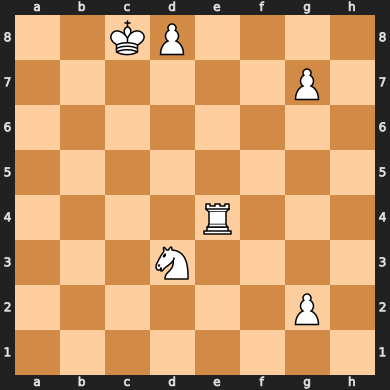

In [16]:
board

In [17]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
           ]

alphabet_lowers = list(map(lambda x: x.lower(), alphabet))

In [18]:
import chess
import collections
import copy
import re
import itertools
import struct

In [19]:
COLORS = [WHITE, BLACK] = [True, False]
COLOR_NAMES = ["black", "white"]

PIECE_TYPES = [PAWN, KNIGHT, BISHOP, ROOK, QUEEN, KING] = range(1, 7)
PIECE_SYMBOLS = ["", "p", "n", "b", "r", "q", "k"]
PIECE_NAMES = ["", "pawn", "knight", "bishop", "rook", "queen", "king"]

UNICODE_PIECE_SYMBOLS = {
    "R": u"♖", "r": u"♜",
    "N": u"♘", "n": u"♞",
    "B": u"♗", "b": u"♝",
    "Q": u"♕", "q": u"♛",
    "K": u"♔", "k": u"♚",
    "P": u"♙", "p": u"♟",
}

alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
            'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
           ]

SIZE = 10

FILE_NAMES = list(map(lambda x: x.lower(), alphabet[:SIZE])) #["a", "b", "c", "d", "e", "f", "g", "h"]

RANK_NAMES = list(map(lambda x: str(int(x)), range(1, SIZE + 1))) #["1", "2", "3", "4", "5", "6", "7", "8"]

STARTING_FEN = "rnbqkbnrkn/pppppppppp/{}/{}/{}/{}/PPPPPPPPPP/RNBQKBNRKB/RNBQKBNRKB/RNBQKBNRKB w KQkq - 0 1".format(SIZE, SIZE, SIZE, SIZE)
"""The FEN for the standard chess starting position."""

STARTING_BOARD_FEN = "rnbqkbnrkn/pppppppppp/{}/{}/{}/{}/PPPPPPPPPP/RNBQKBNRKB/RNBQKBNRKB/RNBQKBNRKB".format(SIZE, SIZE, SIZE, SIZE)
#"rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
"""The board part of the FEN for the standard chess starting position."""

STATUS_VALID = 0
STATUS_NO_WHITE_KING = 1
STATUS_NO_BLACK_KING = 2
STATUS_TOO_MANY_KINGS = 4
STATUS_TOO_MANY_WHITE_PAWNS = 8
STATUS_TOO_MANY_BLACK_PAWNS = 16
STATUS_PAWNS_ON_BACKRANK = 32
STATUS_TOO_MANY_WHITE_PIECES = 64
STATUS_TOO_MANY_BLACK_PIECES = 128
STATUS_BAD_CASTLING_RIGHTS = 256
STATUS_INVALID_EP_SQUARE = 512
STATUS_OPPOSITE_CHECK = 1024
STATUS_EMPTY = 2048
STATUS_RACE_CHECK = 4096
STATUS_RACE_OVER = 8192
STATUS_RACE_MATERIAL = 16384

# SQUARES = [
#     A1, B1, C1, D1, E1, F1, G1, H1,
#     A2, B2, C2, D2, E2, F2, G2, H2,
#     A3, B3, C3, D3, E3, F3, G3, H3,
#     A4, B4, C4, D4, E4, F4, G4, H4,
#     A5, B5, C5, D5, E5, F5, G5, H5,
#     A6, B6, C6, D6, E6, F6, G6, H6,
#     A7, B7, C7, D7, E7, F7, G7, H7,
#     A8, B8, C8, D8, E8, F8, G8, H8] = range(64)


SQUARES = range(SIZE ** 2)

SQUARE_FILES = list(itertools.chain(*[[i for i in range(SIZE)] for j in range(SIZE)]))
SQUARE_RANKS = list(itertools.chain(*[[i] * SIZE for i in range(SIZE)]))

In [140]:
len(SQUARE_FILES)

100

In [20]:
FILE_NAMES, RANK_NAMES, SQUARES

(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'],
 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 range(0, 100))

In [21]:
def square_file(square):
    """Gets the file index of the square where ``0`` is the a file."""
    return square & (SIZE - 1)


def square_rank(square):
    """Gets the rank index of the square where ``0`` is the first rank."""
    return square >> int(np.log2(SIZE)) #3


def square_name2(square):
    """Gets the name of the square, like ``a3``."""
    return FILE_NAMES[square_file(square)] + RANK_NAMES[square_rank(square)]

In [22]:
def square_name(square_file, square_rank):
    """Gets the name of the square, like ``a3``."""
    return FILE_NAMES[square_file] + RANK_NAMES[square_rank]


def square_distance(a, b):
    """
    Gets the distance (i.e., the number of king steps) from square *a* to *b*.
    """
    return max(abs(square_file(a) - square_file(b)), abs(square_rank(a) - square_rank(b)))


# def square_mirror(square):
#     """Mirrors the square vertically."""
#     return square ^ 0x38

# SQUARES_180 = [square_mirror(sq) for sq in SQUARES]
SQUARES_180 = [SQUARES[SIZE * (i-1): SIZE * i] for i in range(1, SIZE)] + [SQUARES[-SIZE:]]
SQUARES_180 = list(itertools.chain(*SQUARES_180[::-1]))
SQUARE_NAMES = [square_name(sq_file, sq_rank) for sq_file, sq_rank in zip(SQUARE_FILES, SQUARE_RANKS)]

In [23]:
np.array(SQUARES_180)

array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [24]:
max(SQUARES_180)

99

In [25]:
np.array([square_file(square) for square in SQUARES])

array([0, 1, 0, 1, 0, 1, 0, 1, 8, 9, 8, 9, 8, 9, 8, 9, 0, 1, 0, 1, 0, 1,
       0, 1, 8, 9, 8, 9, 8, 9, 8, 9, 0, 1, 0, 1, 0, 1, 0, 1, 8, 9, 8, 9,
       8, 9, 8, 9, 0, 1, 0, 1, 0, 1, 0, 1, 8, 9, 8, 9, 8, 9, 8, 9, 0, 1,
       0, 1, 0, 1, 0, 1, 8, 9, 8, 9, 8, 9, 8, 9, 0, 1, 0, 1, 0, 1, 0, 1,
       8, 9, 8, 9, 8, 9, 8, 9, 0, 1, 0, 1])

In [26]:
SQUARE_NAMES2 = [square_rank (sq) for sq in SQUARES]
np.array(SQUARE_NAMES2)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12])

In [66]:
SQUARE_SIZE = 45
MARGIN = 20

In [109]:
PIECES = {
    "b": """<g id="black-bishop" class="black bishop" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M9 36c3.39-.97 10.11.43 13.5-2 3.39 2.43 10.11 1.03 13.5 2 0 0 1.65.54 3 2-.68.97-1.65.99-3 .5-3.39-.97-10.11.46-13.5-1-3.39 1.46-10.11.03-13.5 1-1.354.49-2.323.47-3-.5 1.354-1.94 3-2 3-2zm6-4c2.5 2.5 12.5 2.5 15 0 .5-1.5 0-2 0-2 0-2.5-2.5-4-2.5-4 5.5-1.5 6-11.5-5-15.5-11 4-10.5 14-5 15.5 0 0-2.5 1.5-2.5 4 0 0-.5.5 0 2zM25 8a2.5 2.5 0 1 1-5 0 2.5 2.5 0 1 1 5 0z" fill="#000" stroke-linecap="butt"/><path d="M17.5 26h10M15 30h15m-7.5-14.5v5M20 18h5" stroke="#fff" stroke-linejoin="miter"/></g>""",  # noqa: E501
    "k": """<g id="black-king" class="black king" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M22.5 11.63V6" stroke-linejoin="miter"/><path d="M22.5 25s4.5-7.5 3-10.5c0 0-1-2.5-3-2.5s-3 2.5-3 2.5c-1.5 3 3 10.5 3 10.5" fill="#000" stroke-linecap="butt" stroke-linejoin="miter"/><path d="M11.5 37c5.5 3.5 15.5 3.5 21 0v-7s9-4.5 6-10.5c-4-6.5-13.5-3.5-16 4V27v-3.5c-3.5-7.5-13-10.5-16-4-3 6 5 10 5 10V37z" fill="#000"/><path d="M20 8h5" stroke-linejoin="miter"/><path d="M32 29.5s8.5-4 6.03-9.65C34.15 14 25 18 22.5 24.5l.01 2.1-.01-2.1C20 18 9.906 14 6.997 19.85c-2.497 5.65 4.853 9 4.853 9M11.5 30c5.5-3 15.5-3 21 0m-21 3.5c5.5-3 15.5-3 21 0m-21 3.5c5.5-3 15.5-3 21 0" stroke="#fff"/></g>""",  # noqa: E501
    "n": """<g id="black-knight" class="black knight" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M 22,10 C 32.5,11 38.5,18 38,39 L 15,39 C 15,30 25,32.5 23,18" style="fill:#000000; stroke:#000000;"/><path d="M 24,18 C 24.38,20.91 18.45,25.37 16,27 C 13,29 13.18,31.34 11,31 C 9.958,30.06 12.41,27.96 11,28 C 10,28 11.19,29.23 10,30 C 9,30 5.997,31 6,26 C 6,24 12,14 12,14 C 12,14 13.89,12.1 14,10.5 C 13.27,9.506 13.5,8.5 13.5,7.5 C 14.5,6.5 16.5,10 16.5,10 L 18.5,10 C 18.5,10 19.28,8.008 21,7 C 22,7 22,10 22,10" style="fill:#000000; stroke:#000000;"/><path d="M 9.5 25.5 A 0.5 0.5 0 1 1 8.5,25.5 A 0.5 0.5 0 1 1 9.5 25.5 z" style="fill:#ececec; stroke:#ececec;"/><path d="M 15 15.5 A 0.5 1.5 0 1 1 14,15.5 A 0.5 1.5 0 1 1 15 15.5 z" transform="matrix(0.866,0.5,-0.5,0.866,9.693,-5.173)" style="fill:#ececec; stroke:#ececec;"/><path d="M 24.55,10.4 L 24.1,11.85 L 24.6,12 C 27.75,13 30.25,14.49 32.5,18.75 C 34.75,23.01 35.75,29.06 35.25,39 L 35.2,39.5 L 37.45,39.5 L 37.5,39 C 38,28.94 36.62,22.15 34.25,17.66 C 31.88,13.17 28.46,11.02 25.06,10.5 L 24.55,10.4 z " style="fill:#ececec; stroke:none;"/></g>""",  # noqa: E501
    "p": """<g id="black-pawn" class="black pawn"><path d="M22 9c-2.21 0-4 1.79-4 4 0 .89.29 1.71.78 2.38-1.95 1.12-3.28 3.21-3.28 5.62 0 2.03.94 3.84 2.41 5.03-3 1.06-7.41 5.55-7.41 13.47h23c0-7.92-4.41-12.41-7.41-13.47 1.47-1.19 2.41-3 2.41-5.03 0-2.41-1.33-4.5-3.28-5.62.49-.67.78-1.49.78-2.38 0-2.21-1.79-4-4-4z" stroke="#000" stroke-width="1.5" stroke-linecap="round"/></g>""",  # noqa: E501
    "q": """<g id="black-queen" class="black queen" fill="#000" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><g fill="#000" stroke="none"><circle cx="6" cy="12" r="2.75"/><circle cx="14" cy="9" r="2.75"/><circle cx="22.5" cy="8" r="2.75"/><circle cx="31" cy="9" r="2.75"/><circle cx="39" cy="12" r="2.75"/></g><path d="M9 26c8.5-1.5 21-1.5 27 0l2.5-12.5L31 25l-.3-14.1-5.2 13.6-3-14.5-3 14.5-5.2-13.6L14 25 6.5 13.5 9 26zM9 26c0 2 1.5 2 2.5 4 1 1.5 1 1 .5 3.5-1.5 1-1.5 2.5-1.5 2.5-1.5 1.5.5 2.5.5 2.5 6.5 1 16.5 1 23 0 0 0 1.5-1 0-2.5 0 0 .5-1.5-1-2.5-.5-2.5-.5-2 .5-3.5 1-2 2.5-2 2.5-4-8.5-1.5-18.5-1.5-27 0z" stroke-linecap="butt"/><path d="M11 38.5a35 35 1 0 0 23 0" fill="none" stroke-linecap="butt"/><path d="M11 29a35 35 1 0 1 23 0M12.5 31.5h20M11.5 34.5a35 35 1 0 0 22 0M10.5 37.5a35 35 1 0 0 24 0" fill="none" stroke="#fff"/></g>""",  # noqa: E501
    "r": """<g id="black-rook" class="black rook" fill="#000" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M9 39h27v-3H9v3zM12.5 32l1.5-2.5h17l1.5 2.5h-20zM12 36v-4h21v4H12z" stroke-linecap="butt"/><path d="M14 29.5v-13h17v13H14z" stroke-linecap="butt" stroke-linejoin="miter"/><path d="M14 16.5L11 14h23l-3 2.5H14zM11 14V9h4v2h5V9h5v2h5V9h4v5H11z" stroke-linecap="butt"/><path d="M12 35.5h21M13 31.5h19M14 29.5h17M14 16.5h17M11 14h23" fill="none" stroke="#fff" stroke-width="1" stroke-linejoin="miter"/></g>""",  # noqa: E501
    "B": """<g id="white-bishop" class="white bishop" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><g fill="#fff" stroke-linecap="butt"><path d="M9 36c3.39-.97 10.11.43 13.5-2 3.39 2.43 10.11 1.03 13.5 2 0 0 1.65.54 3 2-.68.97-1.65.99-3 .5-3.39-.97-10.11.46-13.5-1-3.39 1.46-10.11.03-13.5 1-1.354.49-2.323.47-3-.5 1.354-1.94 3-2 3-2zM15 32c2.5 2.5 12.5 2.5 15 0 .5-1.5 0-2 0-2 0-2.5-2.5-4-2.5-4 5.5-1.5 6-11.5-5-15.5-11 4-10.5 14-5 15.5 0 0-2.5 1.5-2.5 4 0 0-.5.5 0 2zM25 8a2.5 2.5 0 1 1-5 0 2.5 2.5 0 1 1 5 0z"/></g><path d="M17.5 26h10M15 30h15m-7.5-14.5v5M20 18h5" stroke-linejoin="miter"/></g>""",  # noqa: E501
    "K": """<g id="white-king" class="white king" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M22.5 11.63V6M20 8h5" stroke-linejoin="miter"/><path d="M22.5 25s4.5-7.5 3-10.5c0 0-1-2.5-3-2.5s-3 2.5-3 2.5c-1.5 3 3 10.5 3 10.5" fill="#fff" stroke-linecap="butt" stroke-linejoin="miter"/><path d="M11.5 37c5.5 3.5 15.5 3.5 21 0v-7s9-4.5 6-10.5c-4-6.5-13.5-3.5-16 4V27v-3.5c-3.5-7.5-13-10.5-16-4-3 6 5 10 5 10V37z" fill="#fff"/><path d="M11.5 30c5.5-3 15.5-3 21 0m-21 3.5c5.5-3 15.5-3 21 0m-21 3.5c5.5-3 15.5-3 21 0"/></g>""",  # noqa: E501
    "N": """<g id="white-knight" class="white knight" fill="none" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M 22,10 C 32.5,11 38.5,18 38,39 L 15,39 C 15,30 25,32.5 23,18" style="fill:#ffffff; stroke:#000000;"/><path d="M 24,18 C 24.38,20.91 18.45,25.37 16,27 C 13,29 13.18,31.34 11,31 C 9.958,30.06 12.41,27.96 11,28 C 10,28 11.19,29.23 10,30 C 9,30 5.997,31 6,26 C 6,24 12,14 12,14 C 12,14 13.89,12.1 14,10.5 C 13.27,9.506 13.5,8.5 13.5,7.5 C 14.5,6.5 16.5,10 16.5,10 L 18.5,10 C 18.5,10 19.28,8.008 21,7 C 22,7 22,10 22,10" style="fill:#ffffff; stroke:#000000;"/><path d="M 9.5 25.5 A 0.5 0.5 0 1 1 8.5,25.5 A 0.5 0.5 0 1 1 9.5 25.5 z" style="fill:#000000; stroke:#000000;"/><path d="M 15 15.5 A 0.5 1.5 0 1 1 14,15.5 A 0.5 1.5 0 1 1 15 15.5 z" transform="matrix(0.866,0.5,-0.5,0.866,9.693,-5.173)" style="fill:#000000; stroke:#000000;"/></g>""",  # noqa: E501
    "P": """<g id="white-pawn" class="white pawn"><path d="M22 9c-2.21 0-4 1.79-4 4 0 .89.29 1.71.78 2.38-1.95 1.12-3.28 3.21-3.28 5.62 0 2.03.94 3.84 2.41 5.03-3 1.06-7.41 5.55-7.41 13.47h23c0-7.92-4.41-12.41-7.41-13.47 1.47-1.19 2.41-3 2.41-5.03 0-2.41-1.33-4.5-3.28-5.62.49-.67.78-1.49.78-2.38 0-2.21-1.79-4-4-4z" fill="#fff" stroke="#000" stroke-width="1.5" stroke-linecap="round"/></g>""",  # noqa: E501
    "Q": """<g id="white-queen" class="white queen" fill="#fff" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M8 12a2 2 0 1 1-4 0 2 2 0 1 1 4 0zM24.5 7.5a2 2 0 1 1-4 0 2 2 0 1 1 4 0zM41 12a2 2 0 1 1-4 0 2 2 0 1 1 4 0zM16 8.5a2 2 0 1 1-4 0 2 2 0 1 1 4 0zM33 9a2 2 0 1 1-4 0 2 2 0 1 1 4 0z"/><path d="M9 26c8.5-1.5 21-1.5 27 0l2-12-7 11V11l-5.5 13.5-3-15-3 15-5.5-14V25L7 14l2 12zM9 26c0 2 1.5 2 2.5 4 1 1.5 1 1 .5 3.5-1.5 1-1.5 2.5-1.5 2.5-1.5 1.5.5 2.5.5 2.5 6.5 1 16.5 1 23 0 0 0 1.5-1 0-2.5 0 0 .5-1.5-1-2.5-.5-2.5-.5-2 .5-3.5 1-2 2.5-2 2.5-4-8.5-1.5-18.5-1.5-27 0z" stroke-linecap="butt"/><path d="M11.5 30c3.5-1 18.5-1 22 0M12 33.5c6-1 15-1 21 0" fill="none"/></g>""",  # noqa: E501
    "R": """<g id="white-rook" class="white rook" fill="#fff" fill-rule="evenodd" stroke="#000" stroke-width="1.5" stroke-linecap="round" stroke-linejoin="round"><path d="M9 39h27v-3H9v3zM12 36v-4h21v4H12zM11 14V9h4v2h5V9h5v2h5V9h4v5" stroke-linecap="butt"/><path d="M34 14l-3 3H14l-3-3"/><path d="M31 17v12.5H14V17" stroke-linecap="butt" stroke-linejoin="miter"/><path d="M31 29.5l1.5 2.5h-20l1.5-2.5"/><path d="M11 14h23" fill="none" stroke-linejoin="miter"/></g>""",  # noqa: E501
}

COORDS = {
    "1": """<path d="M6.754 26.996h2.578v-8.898l-2.805.562v-1.437l2.79-.563h1.578v10.336h2.578v1.328h-6.72z"/>""",  # noqa: E501
    "2": """<path d="M8.195 26.996h5.508v1.328H6.297v-1.328q.898-.93 2.445-2.492 1.555-1.57 1.953-2.024.758-.851 1.055-1.437.305-.594.305-1.164 0-.93-.657-1.516-.648-.586-1.695-.586-.742 0-1.57.258-.82.258-1.758.781v-1.593q.953-.383 1.781-.578.828-.196 1.516-.196 1.812 0 2.89.906 1.079.907 1.079 2.422 0 .72-.274 1.368-.265.64-.976 1.515-.196.227-1.243 1.313-1.046 1.078-2.953 3.023z"/>""",  # noqa: E501
    "3": """<path d="M11.434 22.035q1.132.242 1.765 1.008.64.766.64 1.89 0 1.727-1.187 2.672-1.187.946-3.375.946-.734 0-1.515-.149-.774-.14-1.602-.43V26.45q.656.383 1.438.578.78.196 1.632.196 1.485 0 2.258-.586.782-.586.782-1.703 0-1.032-.727-1.61-.719-.586-2.008-.586h-1.36v-1.297h1.423q1.164 0 1.78-.46.618-.47.618-1.344 0-.899-.64-1.375-.633-.485-1.82-.485-.65 0-1.391.141-.743.14-1.633.437V16.95q.898-.25 1.68-.375.788-.125 1.484-.125 1.797 0 2.844.82 1.046.813 1.046 2.204 0 .968-.554 1.64-.555.664-1.578.922z"/>""",  # noqa: E501
    "4": """<path d="M11.016 18.035L7.03 24.262h3.985zm-.414-1.375h1.984v7.602h1.664v1.312h-1.664v2.75h-1.57v-2.75H5.75v-1.523z"/>""",  # noqa: E501
    "5": """<path d="M6.719 16.66h6.195v1.328h-4.75v2.86q.344-.118.688-.172.343-.063.687-.063 1.953 0 3.094 1.07 1.14 1.07 1.14 2.899 0 1.883-1.171 2.93-1.172 1.039-3.305 1.039-.735 0-1.5-.125-.758-.125-1.57-.375v-1.586q.703.383 1.453.57.75.188 1.586.188 1.351 0 2.14-.711.79-.711.79-1.93 0-1.219-.79-1.93-.789-.71-2.14-.71-.633 0-1.266.14-.625.14-1.281.438z"/>""",  # noqa: E501
    "6": """<path d="M10.137 21.863q-1.063 0-1.688.727-.617.726-.617 1.992 0 1.258.617 1.992.625.727 1.688.727 1.062 0 1.68-.727.624-.734.624-1.992 0-1.266-.625-1.992-.617-.727-1.68-.727zm3.133-4.945v1.437q-.594-.28-1.204-.43-.601-.148-1.195-.148-1.562 0-2.39 1.055-.82 1.055-.938 3.188.46-.68 1.156-1.04.696-.367 1.531-.367 1.758 0 2.774 1.07 1.023 1.063 1.023 2.899 0 1.797-1.062 2.883-1.063 1.086-2.828 1.086-2.024 0-3.094-1.547-1.07-1.555-1.07-4.5 0-2.766 1.312-4.406 1.313-1.649 3.524-1.649.593 0 1.195.117.61.118 1.266.352z"/>""",  # noqa: E501
    "7": """<path d="M6.25 16.66h7.5v.672L9.516 28.324H7.867l3.985-10.336H6.25z"/>""",  # noqa: E501
    "8": """<path d="M10 22.785q-1.125 0-1.773.602-.641.601-.641 1.656t.64 1.656q.649.602 1.774.602t1.773-.602q.649-.61.649-1.656 0-1.055-.649-1.656-.64-.602-1.773-.602zm-1.578-.672q-1.016-.25-1.586-.945-.563-.695-.563-1.695 0-1.399.993-2.211 1-.813 2.734-.813 1.742 0 2.734.813.993.812.993 2.21 0 1-.57 1.696-.563.695-1.571.945 1.14.266 1.773 1.04.641.773.641 1.89 0 1.695-1.04 2.602-1.03.906-2.96.906t-2.969-.906Q6 26.738 6 25.043q0-1.117.64-1.89.641-.774 1.782-1.04zm-.578-2.492q0 .906.562 1.414.57.508 1.594.508 1.016 0 1.586-.508.578-.508.578-1.414 0-.906-.578-1.414-.57-.508-1.586-.508-1.023 0-1.594.508-.562.508-.562 1.414z"/>""",  # noqa: E501
    "a": """<path d="M23.328 10.016q-1.742 0-2.414.398-.672.398-.672 1.36 0 .765.5 1.218.508.445 1.375.445 1.196 0 1.914-.843.727-.852.727-2.258v-.32zm2.867-.594v4.992h-1.437v-1.328q-.492.797-1.227 1.18-.734.375-1.797.375-1.343 0-2.14-.75-.79-.758-.79-2.024 0-1.476.985-2.226.992-.75 2.953-.75h2.016V8.75q0-.992-.656-1.531-.649-.547-1.829-.547-.75 0-1.46.18-.711.18-1.368.539V6.062q.79-.304 1.532-.453.742-.156 1.445-.156 1.898 0 2.836.984.937.985.937 2.985z"/>""",  # noqa: E501
    "b": """<path d="M24.922 10.047q0-1.586-.656-2.485-.649-.906-1.79-.906-1.14 0-1.796.906-.649.899-.649 2.485 0 1.586.649 2.492.656.898 1.797.898 1.14 0 1.789-.898.656-.906.656-2.492zm-4.89-3.055q.452-.781 1.14-1.156.695-.383 1.656-.383 1.594 0 2.586 1.266 1 1.265 1 3.328 0 2.062-1 3.328-.992 1.266-2.586 1.266-.96 0-1.656-.375-.688-.383-1.14-1.164v1.312h-1.446V2.258h1.445z"/>""",  # noqa: E501
    "c": """<path d="M25.96 6v1.344q-.608-.336-1.226-.5-.609-.172-1.234-.172-1.398 0-2.172.89-.773.883-.773 2.485 0 1.601.773 2.492.774.883 2.172.883.625 0 1.234-.164.618-.172 1.227-.508v1.328q-.602.281-1.25.422-.64.14-1.367.14-1.977 0-3.14-1.242-1.165-1.242-1.165-3.351 0-2.14 1.172-3.367 1.18-1.227 3.227-1.227.664 0 1.296.14.633.134 1.227.407z"/>""",  # noqa: E501
    "d": """<path d="M24.973 6.992V2.258h1.437v12.156h-1.437v-1.312q-.453.78-1.149 1.164-.687.375-1.656.375-1.586 0-2.586-1.266-.992-1.266-.992-3.328 0-2.063.992-3.328 1-1.266 2.586-1.266.969 0 1.656.383.696.375 1.149 1.156zm-4.899 3.055q0 1.586.649 2.492.656.898 1.797.898 1.14 0 1.796-.898.657-.906.657-2.492 0-1.586-.657-2.485-.656-.906-1.796-.906-1.141 0-1.797.906-.649.899-.649 2.485z"/>""",  # noqa: E501
    "e": """<path d="M26.555 9.68v.703h-6.61q.094 1.484.89 2.265.806.774 2.235.774.828 0 1.602-.203.781-.203 1.547-.61v1.36q-.774.328-1.586.5-.813.172-1.649.172-2.093 0-3.32-1.22-1.219-1.218-1.219-3.296 0-2.148 1.157-3.406 1.164-1.266 3.132-1.266 1.766 0 2.79 1.14 1.03 1.134 1.03 3.087zm-1.438-.422q-.015-1.18-.664-1.883-.64-.703-1.703-.703-1.203 0-1.93.68-.718.68-.828 1.914z"/>""",  # noqa: E501
    "f": """<path d="M25.285 2.258v1.195H23.91q-.773 0-1.078.313-.297.312-.297 1.125v.773h2.367v1.117h-2.367v7.633H21.09V6.781h-1.375V5.664h1.375v-.61q0-1.46.68-2.124.68-.672 2.156-.672z"/>""",  # noqa: E501
    "g": """<path d="M24.973 9.937q0-1.562-.649-2.421-.64-.86-1.804-.86-1.157 0-1.805.86-.64.859-.64 2.421 0 1.555.64 2.415.648.859 1.805.859 1.164 0 1.804-.86.649-.859.649-2.414zm1.437 3.391q0 2.234-.992 3.32-.992 1.094-3.04 1.094-.757 0-1.429-.117-.672-.11-1.304-.344v-1.398q.632.344 1.25.508.617.164 1.257.164 1.414 0 2.118-.743.703-.734.703-2.226v-.711q-.446.773-1.141 1.156-.695.383-1.664.383-1.61 0-2.594-1.227-.984-1.226-.984-3.25 0-2.03.984-3.257.985-1.227 2.594-1.227.969 0 1.664.383t1.14 1.156V5.664h1.438z"/>""",  # noqa: E501
    "h": """<path d="M26.164 9.133v5.281h-1.437V9.18q0-1.243-.485-1.86-.484-.617-1.453-.617-1.164 0-1.836.742-.672.742-.672 2.024v4.945h-1.445V2.258h1.445v4.765q.516-.789 1.211-1.18.703-.39 1.617-.39 1.508 0 2.282.938.773.93.773 2.742z"/>""",  # noqa: E501
}

XX = """<g id="xx"><path d="M35.865 9.135a1.89 1.89 0 0 1 0 2.673L25.173 22.5l10.692 10.692a1.89 1.89 0 0 1 0 2.673 1.89 1.89 0 0 1-2.673 0L22.5 25.173 11.808 35.865a1.89 1.89 0 0 1-2.673 0 1.89 1.89 0 0 1 0-2.673L19.827 22.5 9.135 11.808a1.89 1.89 0 0 1 0-2.673 1.89 1.89 0 0 1 2.673 0L22.5 19.827 33.192 9.135a1.89 1.89 0 0 1 2.673 0z" fill="#000" stroke="#fff" stroke-width="1.688"/></g>"""  # noqa: E501

CHECK_GRADIENT = """<radialGradient id="check_gradient"><stop offset="0%" stop-color="#ff0000" stop-opacity="1.0" /><stop offset="50%" stop-color="#e70000" stop-opacity="1.0" /><stop offset="100%" stop-color="#9e0000" stop-opacity="0.0" /></radialGradient>"""  # noqa: E501

DEFAULT_COLORS = {
    "square light": "#ffce9e",
    "square dark": "#d18b47",
    "square dark lastmove": "#aaa23b",
    "square light lastmove": "#cdd16a",
    "margin": "#212121",
    "coord": "#e5e5e5",
    "arrow green": "#15781B80",
    "arrow red": "#88202080",
    "arrow yellow": "#e68f00b3",
    "arrow blue": "#00308880",
}

In [127]:
def _coord(text: str, x: int, y: int, width: int, height: int, horizontal: bool, margin: int, *, color: str, opacity: float) -> ET.Element:
    scale = margin / MARGIN

    if horizontal:
        x += int(width - scale * width) // 2
    else:
        y += int(height - scale * height) // 2

    t = ET.Element("g", _attrs({
        "transform": f"translate({x}, {y}) scale({scale}, {scale})",
        "fill": color,
        "stroke": color,
        "opacity": opacity if opacity < 1.0 else None,
    }))
    t.append(ET.fromstring(COORDS[text]))
    return t

def _attrs(attrs: Dict[str, Union[str, int, float, None]]) -> Dict[str, str]:
    return {k: str(v) for k, v in attrs.items() if v is not None}

In [128]:
def _color(colors, color):
    color = colors.get(color, DEFAULT_COLORS[color])
    if color.startswith("#"):
        try:
            if len(color) == 5:
                return color[:4], int(color[4], 16) / 0xf
            elif len(color) == 9:
                return color[:7], int(color[7:], 16) / 0xff
        except ValueError:
            pass  # Ignore invalid hex value
    return color, 1.0

In [129]:
def _svg(viewbox, size):
    svg = ET.Element("svg", {
        "xmlns": "http://www.w3.org/2000/svg",
        "version": "1.1",
        "xmlns:xlink": "http://www.w3.org/1999/xlink",
        "viewBox": f"0 0 {viewbox:d} {viewbox:d}",
    })

    if size is not None:
        svg.set("width", str(size))
        svg.set("height", str(size))

    return svg

In [137]:
len(BB_SQUARES)

100

In [141]:
def svg_board(board=None, *,
          orientation=chess.WHITE,
          lastmove=None,
          check=None,
          arrows=[],
          squares=None,
          size=None,
          coordinates=True,
          colors={},
          flipped=False,
          style=None) -> str:
     
    orientation ^= flipped
    margin = 15 if coordinates else 0
    svg = _svg(SIZE * SQUARE_SIZE + 2 * margin, size)

    if style:
        ET.SubElement(svg, "style").text = style

    defs = ET.SubElement(svg, "defs")
    if board:
        for piece_color in chess.COLORS:
            for piece_type in chess.PIECE_TYPES:
                if board.pieces_mask(piece_type, piece_color):
                    defs.append(ET.fromstring(PIECES[chess.Piece(piece_type, piece_color).symbol()]))

    squares = chess.SquareSet(squares) if squares else chess.SquareSet()
    if squares:
        defs.append(ET.fromstring(XX))

    if check is not None:
        defs.append(ET.fromstring(CHECK_GRADIENT))

    # Render coordinates.
    if coordinates:
        margin_color, margin_opacity = _color(colors, "margin")
        ET.SubElement(svg, "rect", _attrs({
            "x": 0,
            "y": 0,
            "width": 2 * margin + SIZE * SQUARE_SIZE,
            "height": 2 * margin + SIZE * SQUARE_SIZE,
            "fill": margin_color,
            "opacity": margin_opacity if margin_opacity < 1.0 else None,
        }))
        coord_color, coord_opacity = _color(colors, "coord")
        for file_index, file_name in enumerate(chess.FILE_NAMES):
            x = (file_index if orientation else (SIZE-1) - file_index) * SQUARE_SIZE + margin
            svg.append(_coord(file_name, x, 0, SQUARE_SIZE, margin, True, margin, color=coord_color, opacity=coord_opacity))
            svg.append(_coord(file_name, x, margin + SIZE * SQUARE_SIZE, SQUARE_SIZE, margin, True, margin, color=coord_color, opacity=coord_opacity))
        for rank_index, rank_name in enumerate(chess.RANK_NAMES):
            y = ((SIZE-1) - rank_index if orientation else rank_index) * SQUARE_SIZE + margin
            svg.append(_coord(rank_name, 0, y, margin, SQUARE_SIZE, False, margin, color=coord_color, opacity=coord_opacity))
            svg.append(_coord(rank_name, margin + SIZE * SQUARE_SIZE, y, margin, SQUARE_SIZE, False, margin, color=coord_color, opacity=coord_opacity))

    # Render board.
    for square, bb in enumerate(BB_SQUARES):
        file_index = SQUARE_FILES[square] #square_file(square)
        rank_index = SQUARE_RANKS[square] #square_rank(square)

        x = (file_index if orientation else (SIZE-1) - file_index) * SQUARE_SIZE + margin
        y = ((SIZE-1) - rank_index if orientation else rank_index) * SQUARE_SIZE + margin

        cls = ["square", "light" if chess.BB_LIGHT_SQUARES & bb else "dark"]
        if lastmove and square in [lastmove.from_square, lastmove.to_square]:
            cls.append("lastmove")
        fill_color, fill_opacity = _color(colors, " ".join(cls))

        cls.append(SQUARE_NAMES[square])

        ET.SubElement(svg, "rect", _attrs({
            "x": x,
            "y": y,
            "width": SQUARE_SIZE,
            "height": SQUARE_SIZE,
            "class": " ".join(cls),
            "stroke": "none",
            "fill": fill_color,
            "opacity": fill_opacity if fill_opacity < 1.0 else None,
        }))

    # Render check mark.
    if check is not None:
        file_index = SQUARE_FILES[square] #square_file(check)
        rank_index = SQUARE_RANKS[square] #square_rank(check)

        x = (file_index if orientation else (SIZE-1) - file_index) * SQUARE_SIZE + margin
        y = ((SIZE-1) - rank_index if orientation else rank_index) * SQUARE_SIZE + margin

        ET.SubElement(svg, "rect", _attrs({
            "x": x,
            "y": y,
            "width": SQUARE_SIZE,
            "height": SQUARE_SIZE,
            "class": "check",
            "fill": "url(#check_gradient)",
        }))

    # Render pieces and selected squares.
    for square, bb in enumerate(BB_SQUARES):
        file_index = SQUARE_FILES[square] #square_file(square)
        rank_index = SQUARE_RANKS[square] #square_rank(square)

        x = (file_index if orientation else (SIZE-1) - file_index) * SQUARE_SIZE + margin
        y = ((SIZE-1) - rank_index if orientation else rank_index) * SQUARE_SIZE + margin

        if board is not None:
            piece = board.piece_at(square)
            if piece:
                ET.SubElement(svg, "use", {
                    "xlink:href": f"#{chess.COLOR_NAMES[piece.color]}-{chess.PIECE_NAMES[piece.piece_type]}",
                    "transform": f"translate({x:d}, {y:d})",
                })

        # Render selected squares.
        if squares is not None and square in squares:
            ET.SubElement(svg, "use", _attrs({
                "xlink:href": "#xx",
                "x": x,
                "y": y,
            }))

    # Render arrows.
    for arrow in arrows:
        try:
            tail, head, color = arrow.tail, arrow.head, arrow.color  # type: ignore
        except AttributeError:
            tail, head = arrow  # type: ignore
            color = "green"

        try:
            color, opacity = _color(colors, " ".join(["arrow", color]))
        except KeyError:
            opacity = 1.0

        tail_file = SQUARE_FILES[tail] #square_file(tail)
        tail_rank = SQUARE_RANKS[tail] #square_rank(tail)
        head_file = SQUARE_FILES[head] #square_file(head)
        head_rank = SQUARE_RANKS[head] #square_rank(head)

        xtail = margin + (tail_file + 0.5 if orientation else 7.5 - tail_file) * SQUARE_SIZE
        ytail = margin + (7.5 - tail_rank if orientation else tail_rank + 0.5) * SQUARE_SIZE
        xhead = margin + (head_file + 0.5 if orientation else 7.5 - head_file) * SQUARE_SIZE
        yhead = margin + (7.5 - head_rank if orientation else head_rank + 0.5) * SQUARE_SIZE

        if (head_file, head_rank) == (tail_file, tail_rank):
            ET.SubElement(svg, "circle", _attrs({
                "cx": xhead,
                "cy": yhead,
                "r": SQUARE_SIZE * 0.9 / 2,
                "stroke-width": SQUARE_SIZE * 0.1,
                "stroke": color,
                "opacity": opacity if opacity < 1.0 else None,
                "fill": "none",
                "class": "circle",
            }))
        else:
            marker_size = 0.75 * SQUARE_SIZE
            marker_margin = 0.1 * SQUARE_SIZE

            dx, dy = xhead - xtail, yhead - ytail
            hypot = math.hypot(dx, dy)

            shaft_x = xhead - dx * (marker_size + marker_margin) / hypot
            shaft_y = yhead - dy * (marker_size + marker_margin) / hypot

            xtip = xhead - dx * marker_margin / hypot
            ytip = yhead - dy * marker_margin / hypot

            ET.SubElement(svg, "line", _attrs({
                "x1": xtail,
                "y1": ytail,
                "x2": shaft_x,
                "y2": shaft_y,
                "stroke": color,
                "opacity": opacity if opacity < 1.0 else None,
                "stroke-width": SQUARE_SIZE * 0.2,
                "stroke-linecap": "butt",
                "class": "arrow",
            }))

            marker = [(xtip, ytip),
                      (shaft_x + dy * 0.5 * marker_size / hypot,
                       shaft_y - dx * 0.5 * marker_size / hypot),
                      (shaft_x - dy * 0.5 * marker_size / hypot,
                       shaft_y + dx * 0.5 * marker_size / hypot)]

            ET.SubElement(svg, "polygon", _attrs({
                "points": " ".join(f"{x},{y}" for x, y in marker),
                "fill": color,
                "opacity": opacity if opacity < 1.0 else None,
                "class": "arrow",
            }))

    return SvgWrapper(ET.tostring(svg).decode("utf-8"))

In [142]:
BB_VOID = 0
BB_ALL = 0xffffffffffffffff

BB_SQUARES = [1 << sq for sq in SQUARES]

BB_CORNERS = BB_SQUARES[0] | BB_SQUARES[SIZE - 1] | BB_SQUARES[-(SIZE - 1)] | BB_SQUARES[-1]

BB_LIGHT_SQUARES = 0x55aa55aa55aa55aa
BB_DARK_SQUARES = 0xaa55aa55aa55aa55

BB_FILES = [0x0101010101010101 << i for i in range(SIZE)]

BB_RANKS = [0xff << (SIZE * i) for i in range(SIZE)]

BB_BACKRANKS = BB_RANKS[0] | BB_RANKS[-1]


def lsb(bb):
    return (bb & -bb).bit_length() - 1


def scan_forward(bb):
    while bb:
        r = bb & -bb
        yield r.bit_length() - 1
        bb ^= r


def msb(bb):
    return bb.bit_length() - 1


def scan_reversed(bb, _BB_SQUARES=BB_SQUARES):
    while bb:
        r = bb.bit_length() - 1
        yield r
        bb ^= _BB_SQUARES[r]


def popcount(bb, _bin=bin):
    return _bin(bb).count("1")


def bswap(bb, _be=struct.Struct(">Q"), _le=struct.Struct("<Q")):
    return _be.unpack(_le.pack(bb))[0]


def _sliding_attacks(square, occupied, deltas):
    attacks = 0

    for delta in deltas:
        sq = square

        while True:
            sq += delta
            if not (0 <= sq < SIZE ** 2) or square_distance(sq, sq - delta) > 2:
                break

            attacks |= BB_SQUARES[sq]

            if occupied & BB_SQUARES[sq]:
                break

    return attacks


BB_KNIGHT_ATTACKS = [_sliding_attacks(sq, BB_ALL, [17, 15, 10, 6, -17, -15, -10, -6]) for sq in SQUARES]
BB_KING_ATTACKS = [_sliding_attacks(sq, BB_ALL, [9, 8, 7, 1, -9, -8, -7, -1]) for sq in SQUARES]
BB_PAWN_ATTACKS = [[_sliding_attacks(sq, BB_ALL, deltas) for sq in SQUARES] for deltas in [[-7, -9], [7, 9]]]

def _carry_rippler(mask):
    # Carry-Rippler trick to iterate subsets of mask.
    subset = 0
    while True:
        yield subset
        subset = (subset - mask) & mask
        if not subset:
            break


SAN_REGEX = "^([NBKRQ])?([a-h])?([1-{}])?[\-x]?([a-h][1-{}])(=?[nbrqkNBRQK])?(\+|#)?\Z".format(SIZE, SIZE)
#re.compile(r"^([NBKRQ])?([a-h])?([1-8])?[\-x]?([a-h][1-8])(=?[nbrqkNBRQK])?(\+|#)?\Z")

FEN_CASTLING_REGEX = "^(?:-|[KQ{upper}]{{0,2}}[kq{lower}]{{0,2}})\Z".format(upper=alphabet[:SIZE],
                                                                            lower=FILE_NAMES[:SIZE]
                                                                            )
#re.compile(r"^(?:-|[KQABCDEFGH]{0,2}[kqabcdefgh]{0,2})\Z")


class Piece(object):
    """A piece with type and color."""

    def __init__(self, piece_type, color):
        self.piece_type = piece_type
        self.color = color

    def symbol(self):
        """
        Gets the symbol ``P``, ``N``, ``B``, ``R``, ``Q`` or ``K`` for white
        pieces or the lower-case variants for the black pieces.
        """
        if self.color == WHITE:
            return PIECE_SYMBOLS[self.piece_type].upper()
        else:
            return PIECE_SYMBOLS[self.piece_type]

    def unicode_symbol(self, invert_color=False):
        """
        Gets the Unicode character for the piece.
        """
        if not invert_color:
            return UNICODE_PIECE_SYMBOLS[self.symbol()]
        else:
            return UNICODE_PIECE_SYMBOLS[self.symbol().swapcase()]

    def __hash__(self):
        return hash(self.piece_type * (self.color + 1))

    def __repr__(self):
        return "Piece.from_symbol('{0}')".format(self.symbol())

    def __str__(self):
        return self.symbol()

    def _repr_svg_(self):
        import chess.svg
        return chess.svg.piece(self, size=45)

    def __eq__(self, other):
        ne = self.__ne__(other)
        return NotImplemented if ne is NotImplemented else not ne

    def __ne__(self, other):
        try:
            if self.piece_type != other.piece_type:
                return True
            elif self.color != other.color:
                return True
            else:
                return False
        except AttributeError:
            return NotImplemented

    @classmethod
    def from_symbol(cls, symbol):
        """
        Creates a :class:`~chess.Piece` instance from a piece symbol.
        :raises: :exc:`ValueError` if the symbol is invalid.
        """
        if symbol.islower():
            return cls(PIECE_SYMBOLS.index(symbol), BLACK)
        else:
            return cls(PIECE_SYMBOLS.index(symbol.lower()), WHITE)


class Move(object):
    """
    Represents a move from a square to a square and possibly the promotion
    piece type.
    Drops and null moves are supported.
    """

    def __init__(self, from_square, to_square, promotion=None, drop=None):
        self.from_square = from_square
        self.to_square = to_square
        self.promotion = promotion
        self.drop = drop

    def uci(self):
        """
        Gets an UCI string for the move.
        For example, a move from a7 to a8 would be ``a7a8`` or ``a7a8q``
        (if the latter is a promotion to a queen).
        The UCI representation of a null move is ``0000``.
        """
        if self.drop:
            return PIECE_SYMBOLS[self.drop].upper() + "@" + SQUARE_NAMES[self.to_square]
        elif self.promotion:
            return SQUARE_NAMES[self.from_square] + SQUARE_NAMES[self.to_square] + PIECE_SYMBOLS[self.promotion]
        elif self:
            return SQUARE_NAMES[self.from_square] + SQUARE_NAMES[self.to_square]
        else:
            return "0000"

    def __bool__(self):
        return bool(self.from_square or self.to_square or self.promotion or self.drop)

    __nonzero__ = __bool__

    def __eq__(self, other):
        ne = self.__ne__(other)
        return NotImplemented if ne is NotImplemented else not ne

    def __ne__(self, other):
        try:
            if self.from_square != other.from_square:
                return True
            elif self.to_square != other.to_square:
                return True
            elif self.promotion != other.promotion:
                return True
            elif self.drop != other.drop:
                return True
            else:
                return False
        except AttributeError:
            return NotImplemented

    def __repr__(self):
        return "Move.from_uci('{0}')".format(self.uci())

    def __str__(self):
        return self.uci()

    def __hash__(self):
        return hash((self.to_square, self.from_square, self.promotion, self.drop))

    def __copy__(self):
        return type(self)(self.from_square, self.to_square, self.promotion, self.drop)

    def __deepcopy__(self, memo):
        move = self.__copy__()
        memo[id(self)] = move
        return move

    @classmethod
    def from_uci(cls, uci):
        """
        Parses an UCI string.
        :raises: :exc:`ValueError` if the UCI string is invalid.
        """
        if uci == "0000":
            return cls.null()
        elif len(uci) == 4 and "@" == uci[1]:
            drop = PIECE_SYMBOLS.index(uci[0].lower())
            square = SQUARE_NAMES.index(uci[2:])
            return cls(square, square, drop=drop)
        elif len(uci) == 4:
            return cls(SQUARE_NAMES.index(uci[0:2]), SQUARE_NAMES.index(uci[2:4]))
        elif len(uci) == 5:
            promotion = PIECE_SYMBOLS.index(uci[4])
            return cls(SQUARE_NAMES.index(uci[0:2]), SQUARE_NAMES.index(uci[2:4]), promotion=promotion)
        else:
            raise ValueError("expected uci string to be of length 4 or 5: {0}".format(repr(uci)))

    @classmethod
    def null(cls):
        """
        Gets a null move.
        A null move just passes the turn to the other side (and possibly
        forfeits en passant capturing). Null moves evaluate to ``False`` in
        # boolean contexts.
        # >>> import chess
        # >>>
        # >>> bool(chess.Move.null())
        False
        """
        return cls(0, 0)


class BaseBoard(object):
    """
    A board representing the position of chess pieces. See
    :class:`~chess.Board` for a full board with move generation.
    The board is initialized with the standard chess starting position, unless
    otherwise specified in the optional *board_fen* argument. If *board_fen*
    is ``None``, an empty board is created.
    """

    def __init__(self, board_fen=STARTING_BOARD_FEN):
        self.occupied_co = [BB_VOID, BB_VOID]

        if board_fen is None:
            self._clear_board()
        # elif board_fen == STARTING_BOARD_FEN:
        #     self._reset_board()
        else:
            self._set_board_fen(board_fen)

    def _clear_board(self):
        self.pawns = BB_VOID
        self.knights = BB_VOID
        self.bishops = BB_VOID
        self.rooks = BB_VOID
        self.queens = BB_VOID
        self.kings = BB_VOID

        self.promoted = BB_VOID

        self.occupied_co[WHITE] = BB_VOID
        self.occupied_co[BLACK] = BB_VOID
        self.occupied = BB_VOID

    def clear_board(self):
        """Clears the board."""
        self._clear_board()

    def pieces_mask(self, piece_type, color):
        if piece_type == PAWN:
            bb = self.pawns
        elif piece_type == KNIGHT:
            bb = self.knights
        elif piece_type == BISHOP:
            bb = self.bishops
        elif piece_type == ROOK:
            bb = self.rooks
        elif piece_type == QUEEN:
            bb = self.queens
        elif piece_type == KING:
            bb = self.kings

        return bb & self.occupied_co[color]

    def pieces(self, piece_type, color):
        """
        Gets pieces of the given type and color.
        Returns a :class:`set of squares <chess.SquareSet>`.
        """
        return SquareSet(self.pieces_mask(piece_type, color))

    def piece_at(self, square):
        """Gets the :class:`piece <chess.Piece>` at the given square."""
        piece_type = self.piece_type_at(square)
        if piece_type:
            mask = BB_SQUARES[square]
            color = bool(self.occupied_co[WHITE] & mask)
            return Piece(piece_type, color)

    def piece_type_at(self, square):
        """Gets the piece type at the given square."""

        mask = BB_SQUARES[square]

        if not self.occupied & mask:
            return None
        elif self.pawns & mask:
            return PAWN
        elif self.knights & mask:
            return KNIGHT
        elif self.bishops & mask:
            return BISHOP
        elif self.rooks & mask:
            return ROOK
        elif self.queens & mask:
            return QUEEN
        elif self.kings & mask:
            return KING

    def king(self, color):
        """
        Finds the king square of the given side. Returns ``None`` if there
        is no king of that color.
        In variants with king promotions, only non-promoted kings are
        considered.
        """
        king_mask = self.occupied_co[color] & self.kings & ~self.promoted
        if king_mask:
            return msb(king_mask)

    def _remove_piece_at(self, square):
        piece_type = self.piece_type_at(square)
        
        mask = BB_SQUARES[square]

        if piece_type == PAWN:
            self.pawns ^= mask
        elif piece_type == KNIGHT:
            self.knights ^= mask
        elif piece_type == BISHOP:
            self.bishops ^= mask
        elif piece_type == ROOK:
            self.rooks ^= mask
        elif piece_type == QUEEN:
            self.queens ^= mask
        elif piece_type == KING:
            self.kings ^= mask
        else:
            return

        self.occupied ^= mask
        self.occupied_co[WHITE] &= ~mask
        self.occupied_co[BLACK] &= ~mask

        self.promoted &= ~mask

        return piece_type

    def remove_piece_at(self, square):
        """
        Removes the piece from the given square. Returns the
        :class:`~chess.Piece` or ``None`` if the square was already empty.
        """
        color = bool(self.occupied_co[WHITE] & BB_SQUARES[square])
        piece_type = self._remove_piece_at(square)
        if piece_type:
            return Piece(piece_type, color)

    def _set_piece_at(self, square, piece_type, color, promoted=False):
        self._remove_piece_at(square)
        
        mask = BB_SQUARES[square]

        if piece_type == PAWN:
            self.pawns |= mask
        elif piece_type == KNIGHT:
            self.knights |= mask
        elif piece_type == BISHOP:
            self.bishops |= mask
        elif piece_type == ROOK:
            self.rooks |= mask
        elif piece_type == QUEEN:
            self.queens |= mask
        elif piece_type == KING:
            self.kings |= mask

        self.occupied ^= mask
        self.occupied_co[color] ^= mask

        if promoted:
            self.promoted ^= mask

    def set_piece_at(self, square, piece, promoted=False):
        """
        Sets a piece at the given square.
        An existing piece is replaced. Setting *piece* to ``None`` is
        equivalent to :func:`~chess.Board.remove_piece_at()`.
        """
        if piece is None:
            self._remove_piece_at(square)
        else:
            self._set_piece_at(square, piece.piece_type, piece.color, promoted)

    def board_fen(self, promoted=False):
        """
        Gets the board FEN.
        """
        builder = []
        empty = 0

        for square in SQUARES_180:
            piece = self.piece_at(square)

            if not piece:
                empty += 1
            else:
                if empty:
                    builder.append(str(empty))
                    empty = 0
                builder.append(piece.symbol())
                if promoted and BB_SQUARES[square] & self.promoted:
                    builder.append("~")

            if BB_SQUARES[square] & BB_FILES[-1]: #BB_FILE_H:
                if empty:
                    builder.append(str(empty))
                    empty = 0

                if square != SQUARES[SIZE - 1]: #H1:
                    builder.append("/")

        return "".join(builder)

    def _set_board_fen(self, fen):
        # Ensure the FEN is valid.
        rows = fen.split("/")
        if len(rows) != SIZE:
            raise ValueError("expected 8 rows in position part of fen: {0}".format(repr(fen)))

        # Clear the board.
        self._clear_board()

        # Put pieces on the board.
        square_index = 0
        for row in fen.split('/'):
            if row in RANK_NAMES: #["1", "2", "3", "4", "5", "6", "7", "8"]:
                square_index += int(row)
            else:
                for c in row:
                    if c.lower() in ["p", "n", "b", "r", "q", "k"]:
                        piece = Piece.from_symbol(c)
                        self._set_piece_at(SQUARES_180[square_index], piece.piece_type, piece.color)
                        square_index += 1
                    elif c == "~":
                        self.promoted |= BB_SQUARES[SQUARES_180[square_index - 1]]

    def set_board_fen(self, fen):
        """
        Parses a FEN and sets the board from it.
        :raises: :exc:`ValueError` if the FEN string is invalid.
        """
        self._set_board_fen(fen)

    def piece_map(self):
        """
        Gets a dictionary of :class:`pieces <chess.Piece>` by square index.
        """
        result = {}
        for square in scan_reversed(self.occupied):
            result[square] = self.piece_at(square)
        return result

    def _set_piece_map(self, pieces):
        self._clear_board()
        for square, piece in pieces.items():
            self._set_piece_at(square, piece.piece_type, piece.color)

    def set_piece_map(self, pieces):
        """
        Sets up the board from a dictionary of :class:`pieces <chess.Piece>`
        by square index.
        """
        print(pieces)
        self._set_piece_map(pieces)

    def __repr__(self):
        return "{0}('{1}')".format(type(self).__name__, self.board_fen())

    def __str__(self):
        builder = []

        for square in SQUARES_180:
            piece = self.piece_at(square)

            if piece:
                builder.append(piece.symbol())
            else:
                builder.append(".")

            if BB_SQUARES[square] & BB_FILES[-1]: #BB_FILE_H:
                if square != SQUARES[SIZE - 1]: #H1:
                    builder.append("\n")
            else:
                builder.append(" ")

        return "".join(builder)

    def unicode(self, invert_color=False, borders=False):
        builder = []
        for rank_index in range(SIZE - 1, -1, -1): #range(7, -1, -1):
            if borders:
                builder.append("  ")
                builder.append("-" * 2*SIZE + 1) #17
                builder.append("\n")

                builder.append(RANK_NAMES[rank_index])
                builder.append(" ")

            for file_index in range(SIZE):
                square_index = square(file_index, rank_index)

                if borders:
                    builder.append("|")
                elif file_index > 0:
                    builder.append(" ")

                piece = self.piece_at(square_index)

                if piece:
                    builder.append(piece.unicode_symbol(invert_color=invert_color))
                else:
                    builder.append(u"·")

            if borders:
                builder.append("|")

            if borders or rank_index > 0:
                builder.append("\n")

        if borders:
            builder.append("  ")
            builder.append("-" * 2*SIZE + 1) #17
            builder.append("\n")
            #builder.append("   a b c d e f g h")
            builder.append("   " + ' '.join(FILE_NAMES[:SIZE]))

        return "".join(builder)

    def _repr_svg_(self):
        import chess.svg
        #return chess.svg.board(board=self, size=400)
        return svg_board(self, size=400)

    def __eq__(self, board):
        ne = self.__ne__(board)
        return NotImplemented if ne is NotImplemented else not ne

    def __ne__(self, board):
        try:
            if self.occupied != board.occupied:
                return True
            elif self.occupied_co[WHITE] != board.occupied_co[WHITE]:
                return True
            elif self.pawns != board.pawns:
                return True
            elif self.knights != board.knights:
                return True
            elif self.bishops != board.bishops:
                return True
            elif self.rooks != board.rooks:
                return True
            elif self.queens != board.queens:
                return True
            elif self.kings != board.kings:
                return True
            else:
                return False
        except AttributeError:
            return NotImplemented

    def mirror(self):
        """
        Returns a mirrored copy of the board.
        The board is mirrored vertically and piece colors are swapped, so that
        the position is equivalent modulo color.
        """
        board = type(self)(None)

        board.pawns = bswap(self.pawns)
        board.knights = bswap(self.knights)
        board.bishops = bswap(self.bishops)
        board.rooks = bswap(self.rooks)
        board.queens = bswap(self.queens)
        board.kings = bswap(self.kings)

        board.occupied_co[WHITE] = bswap(self.occupied_co[BLACK])
        board.occupied_co[BLACK] = bswap(self.occupied_co[WHITE])
        board.occupied = bswap(self.occupied)
        board.promoted = bswap(self.promoted)

        return board

    def copy(self):
        """Creates a copy of the board."""
        board = type(self)(None)

        board.pawns = self.pawns
        board.knights = self.knights
        board.bishops = self.bishops
        board.rooks = self.rooks
        board.queens = self.queens
        board.kings = self.kings

        board.occupied_co[WHITE] = self.occupied_co[WHITE]
        board.occupied_co[BLACK] = self.occupied_co[BLACK]
        board.occupied = self.occupied
        board.promoted = self.promoted

        return board

    def __copy__(self):
        return self.copy()

    def __deepcopy__(self, memo):
        board = self.copy()
        memo[id(self)] = board
        return board

    @classmethod
    def empty(cls):
        """
        Creates a new empty board. Also see
        :func:`~chess.BaseBoard.clear_board()`.
        """
        return cls(None)

In [143]:
["p", "n", "b", "r", "q", "k"]

['p', 'n', 'b', 'r', 'q', 'k']

In [144]:
fen = 'rnbqkbnrbn/pppppppppp/10/10/10/10/PPPPPPPPPP/RNBQKBNRRN/RNBQKBNRRN/RNBQKBNRRN'
fen8 = 'rnbqkbbn/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'

In [145]:
board = BaseBoard(fen)

In [147]:
board

IndexError: list index out of range

BaseBoard('rnbqkbnrbnpppppppppp16/12/4/8/PPPP/PPPPPPRNBQKB/NRRNRNBQKBNR/RNRNBQKBNRRN')

In [86]:
SIZE

10

In [176]:
RANK_NAMES

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [3]:
import re
from PIL import Image, ImageDraw

class BadChessboard(ValueError):
    pass

def expand_blanks(fen):
    '''Expand the digits in an FEN string into spaces

    >>> expand_blanks("rk4q3")
    'rk    q   '
    '''
    def expand(match):
        return ' ' * int(match.group(0))
    return re.compile(r'\d').sub(expand, fen)

def check_valid(expanded_fen, n):
    '''Asserts an expanded FEN string is valid'''
    match = re.compile(r'([KQBNRPkqbnrp ]{{{n}}}/){{{n}}}$'.format(n=n)).match
    if not match(expanded_fen + '/'):
        raise BadChessboard()

def expand_fen(fen, n):
    '''Preprocesses a fen string into an internal format.

    Each square on the chessboard is represented by a single 
    character in the output string. The rank separator characters
    are removed. Invalid inputs raise a BadChessboard error.
    '''
    expanded = expand_blanks(fen)
    check_valid(expanded, n)
    return expanded.replace('/', '')

def draw_board(n=8, sq_size=(20, 20)):
    '''Return an image of a chessboard.

    The board has n x n squares each of the supplied size.'''
    from itertools import cycle
    def square(i, j):
        return i * sq_size[0], j * sq_size[1]
    opaque_grey_background = 192, 255
    board = Image.new('LA', square(n, n), opaque_grey_background) 
    draw_square = ImageDraw.Draw(board).rectangle
    whites = ((square(i, j), square(i + 1, j + 1))
              for i_start, j in zip(cycle((0, 1)), range(n))
              for i in range(i_start, n, 2))
    for white_square in whites:
        draw_square(white_square, fill='white')
    return board

class DrawChessPosition(object):
    '''Chess position renderer.

    Create an instance of this class, then call 
    '''
    def __init__(self, n):
        '''Initialise, preloading pieces and creating a blank board.''' 
        self.n = n
        self.create_pieces()
        self.create_blank_board()

    def create_pieces(self):
        '''Load the chess pieces from disk.

        Also extracts and caches the alpha masks for these pieces. 
        '''
        whites = 'KQBNRP'
        piece_images = dict(
            zip(whites, (Image.open('pieces/%s.png' % p) for p in whites)))
        blacks = 'kqbnrp'
        piece_images.update(dict(
            zip(blacks, (Image.open('pieces/%s.png' % p) for p in blacks))))
        piece_sizes = set(piece.size for piece in piece_images.values())
        # Sanity check: the pieces should all be the same size
        assert len(piece_sizes) == 1
        self.piece_w, self.piece_h = piece_sizes.pop()
        self.piece_images = piece_images
        self.piece_masks = dict((pc, img.split()[3]) for pc, img in
                                 self.piece_images.items())

    def create_blank_board(self):
        '''Pre-render a blank board.'''
        self.board = draw_board(self.n, sq_size=(self.piece_w, self.piece_h))

    def point(self, i, j):
        '''Return the top left of the square at (i, j).'''
        w, h = self.piece_w, self.piece_h
        return i * h, j * w

    def square(self, i, j):
        '''Return the square at (i, j).'''
        t, l = self.point(i, j)
        b, r = self.point(i + 1, j + 1)
        return t, l, b, r

    def draw(self, fen):
        '''Return an image depicting the input position.

        fen - the first record of a FEN chess position.
        Clients are responsible for resizing this image and saving it,
        if required.
        '''
        board = self.board.copy()
        pieces = expand_fen(fen, self.n)
        images, masks, n = self.piece_images, self.piece_masks, self.n
        pts = (self.point(i, j) for j in range(n) for i in range(n))
        def not_blank(pt_pc):
            return pt_pc[1] != ' '
        for pt, piece in filter(not_blank, zip(pts, pieces)):
            board.paste(images[piece], pt, masks[piece])
        return board

In [6]:
renderer = DrawChessPosition(n=10)
fen = "r2q1rk1nb/B2Q1RK1NB/PP2PPBPNR/1np2np1NP/2Q3B1PR/3PP1b1KN/2N2N2PN/PP3PPPKN/3RKB1Rrn/3RKB1Rrn"
board = renderer.draw(fen)
board.show()

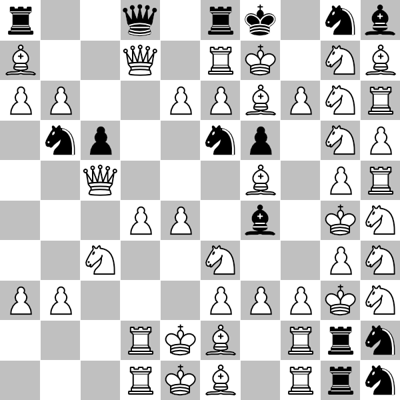

In [12]:
board.resize((400, 400))